In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# Example: generate AR(1) errors
np.random.seed(42)
n = 200
x_t = np.random.normal(size=n)
phi = 0.7
e_t = np.zeros(n)
for t in range(1, n):
    e_t[t] = phi * e_t[t-1] + np.random.normal()

y_t = 2.0 + 0.5 * x_t + e_t

df = pd.DataFrame({'y':y_t, 'x': x_t})
df.head()

,y,x
0,2.248357,0.496714
1,2.288655,-0.138264
2,3.135080,0.647689
3,4.412431,1.523030
4,4.092367,-0.234153


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     23.84
Date:                Mon, 09 Jun 2025   Prob (F-statistic):           2.15e-06
Time:                        05:10:41   Log-Likelihood:                -339.78
No. Observations:                 200   AIC:                             683.6
Df Residuals:                     198   BIC:                             690.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2620      0.094     24.034      0.0

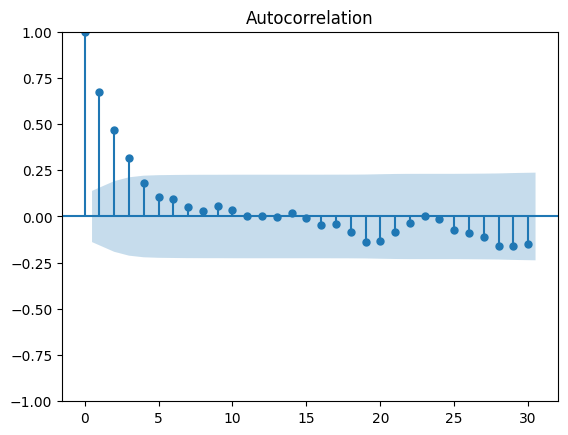

In [13]:
X = sm.add_constant(df['x'])
model_ols = sm.OLS(df['y'], X).fit()

print(model_ols.summary())
residuals = model_ols.resid

tsa.graphics.plot_acf(residuals, lags = 30)
plt.show()

In [16]:
adf_result = tsa.adfuller(residuals)
print("ADF Statistic:", adf_result[0])
print('p-value:',adf_result[1])

ADF Statistic: -6.224366570368856
p-value: 5.1313121876587164e-08


                            OLS Regression Results                            
Dep. Variable:                 y_diff   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     73.80
Date:                Mon, 09 Jun 2025   Prob (F-statistic):           2.63e-15
Time:                        05:15:46   Log-Likelihood:                -296.78
No. Observations:                 199   AIC:                             597.6
Df Residuals:                     197   BIC:                             604.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.077      0.018      0.9

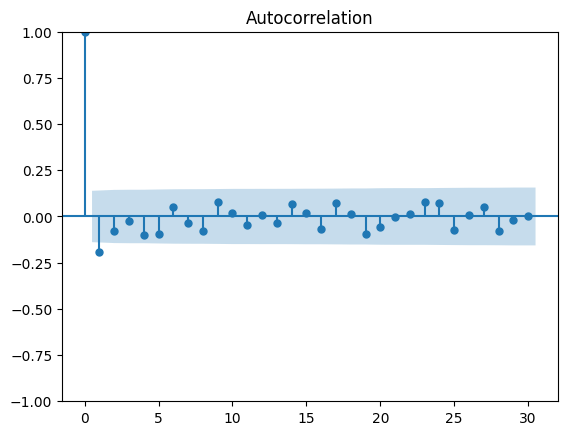

In [20]:
df['y_diff'] = df['y'].diff().dropna()
df['x_diff'] = df['x'].diff().dropna()

# Refit regression on differenced data
X_diff = sm.add_constant(df['x_diff'].dropna())
model_diff = sm.OLS(df['y_diff'].dropna(), X_diff).fit()

print(model_diff.summary())

# Residuals after differencing
resid_diff = model_diff.resid
tsa.graphics.plot_acf(resid_diff, lags=30)
plt.show()


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -280.041
Date:                Mon, 09 Jun 2025   AIC                            568.082
Time:                        05:18:10   BIC                            581.275
Sample:                             0   HQIC                           573.421
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.218     -0.010      0.992      -0.430       0.426
ar.L1          0.6924      0.079      8.808      0.000       0.538       0.846
ma.L1         -0.0441      0.107     -0.411      0.6

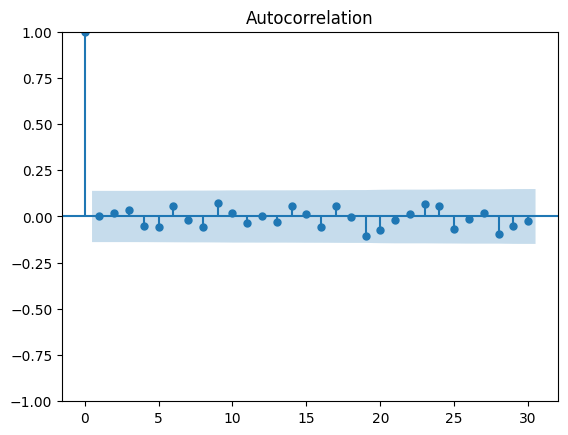

In [22]:
arma_model = tsa.ARIMA(residuals, order = (1, 0 , 1)).fit()
print(arma_model.summary())

arma_resid = arma_model.resid
tsa.graphics.plot_acf(arma_resid, lags = 30)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -291.772
Date:                Mon, 09 Jun 2025   AIC                            591.543
Time:                        05:20:04   BIC                            604.737
Sample:                             0   HQIC                           596.883
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x              0.4871      0.063      7.725      0.000       0.363       0.611
ar.L1          0.9469      0.026     35.777      0.000       0.895       0.999
ma.L1         -0.2088      0.081     -2.590      0.0

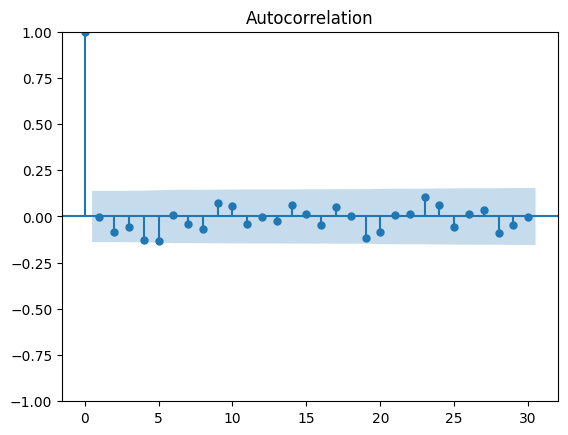

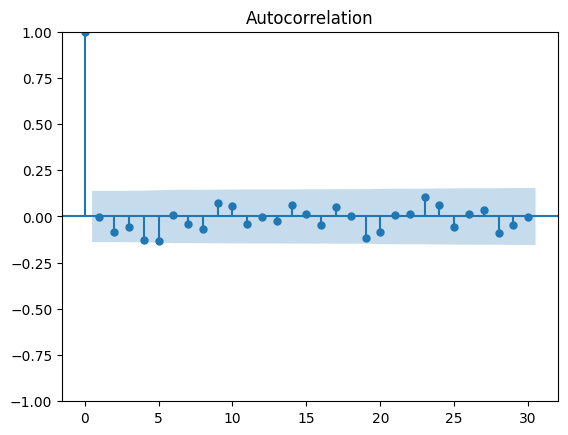

In [25]:
sarimax_model = tsa.SARIMAX(df['y'], exog = df['x'], order =(1, 0, 1)).fit()
print(sarimax_model.summary())
tsa.graphics.plot_acf(sarimax_model.resid, lags = 30)

In [28]:
import statsmodels.api as sm

# Simple OLS
X = sm.add_constant(df['x'])
ols_model = sm.OLS(df['y'], X).fit()

# HC (White)
ols_model_HC = ols_model.get_robustcov_results(cov_type='HC0')
print("HC t-stats:")
print(ols_model_HC.tvalues)

# HAC (Newey-West)
ols_model_HAC = ols_model.get_robustcov_results(cov_type='HAC', maxlags=5)
print("HAC t-stats:")
print(ols_model_HAC.tvalues)


HC t-stats:
[24.06952188  4.66388428]
HAC t-stats:
[13.43955804  3.82527154]


In [31]:
# Example with pmdarima
import pmdarima as pm

model = pm.auto_arima(series, seasonal=False, start_p=0, start_q=0,
                      max_p=5, max_q=5,
                      start_d=0, max_d=2,
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject